# Load libraries and data

In [87]:
from pathlib import Path
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score

In [88]:
train_data = pd.read_csv(Path("..", "data", "processed", "train.csv"))
val_data = pd.read_csv(Path("..", "data", "processed", "val.csv"))

# Parameters

In [89]:
MAX_LEN = 150
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_FILTERS = 64
KERNEL_SIZE = 2
DROPOUT = 0.44
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 6  # toxic, severe_toxic, obscene, threat, insult, identity_hate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}")

Using cuda


# Tokenizer

In [90]:
# Tokenizer (basic word splitting)
def basic_tokenizer(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters
    return text.split()


def build_vocab(texts):
    token_counts = Counter()
    for text in texts:
        cleaned_text = basic_tokenizer(text)
        token_counts.update(cleaned_text)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(token_counts.most_common())}  # Reserve index 0 for padding, 1 for unknown
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab


# Convert texts to numerical sequences
def encode_text(text, vocab, max_len=150):
    tokens = basic_tokenizer(text)
    encoded = [vocab.get(word, vocab["<UNK>"]) for word in tokens[:max_len]]
    return np.pad(encoded, (0, max_len - len(encoded)), constant_values=vocab["<PAD>"])[:max_len]

# Model

In [91]:
# Dataset Class
class ToxicDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=150):
        texts = [encode_text(text, vocab, max_len) for text in texts]
        self.texts = [torch.tensor(text, dtype=torch.long) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.texts[idx],
            "labels": self.labels[idx]
        }


# Load Pretrained Embeddings (GloVe)
def load_glove_embeddings(filepath, vocab, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(vocab), embedding_dim))
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            if word in vocab:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)


# Model: CNN + GRU
class ToxicClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_filters, kernel_size, dropout, num_classes):
        super().__init__()
        # Embedding layers
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        # CNN layer
        self.conv = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding=1)
        self.pool = nn.AdaptiveMaxPool1d(50) # This reduces the sequence length
        # GRU layer
        self.gru = nn.GRU(
            input_size=num_filters,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True)
        # Fully connected layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x) # (batch_size, seq_len, embedding_dim)
        x = x.permute(0, 2, 1) # change shape for conv1d (batch_size, channels, seq_len)
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1) # change shape back for GRU (batch_size, seq_len, channels)
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :]) # take the last time step
        return self.fc(x)


# Training function
def model_train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)

    epochs_list = []
    train_loss_list = []
    train_roc_auc_list = []
    val_loss_list = []
    val_roc_auc_list = []

    for epoch in range(epochs):
        model.train()  # set model to training mode
        total_train_loss = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            outputs = torch.sigmoid(outputs)
            all_preds.append(outputs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())
        
        # Compute Loss
        train_loss = total_train_loss / len(train_loader)

        # Compute AUC_ROC
        all_preds = np.concatenate(all_preds, axis=0).T
        all_labels = np.concatenate(all_labels, axis=0).T
        train_roc_auc = np.mean(
            [roc_auc_score(y_true, y_pred) for y_true, y_pred in zip(all_labels, all_preds)]
        )

        # Validation Step
        model.eval()
        val_preds = []
        val_labels = []
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                
                # Compute validation loss
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                val_preds.append(outputs.cpu().numpy())
                val_labels.append(labels.cpu().numpy())
        
        # Compute validation loss
        val_loss = total_val_loss / len(val_loader)

        # Compute AUC_ROC
        val_preds = np.concatenate(val_preds, axis=0).T
        val_labels = np.concatenate(val_labels, axis=0).T
        val_roc_auc = np.mean(
            [roc_auc_score(y_true, y_pred) for y_true, y_pred in zip(val_labels, val_preds)]
        )

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | AUC_ROC: {train_roc_auc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | AUC_ROC: {val_roc_auc:.4f}")

        epochs_list.append(epoch + 1)
        train_loss_list.append(train_loss)
        train_roc_auc_list.append(train_roc_auc)
        val_loss_list.append(val_loss)
        val_roc_auc_list.append(val_roc_auc)
        
    return {
        "epoch": epochs_list,
        "train_loss": train_loss_list,
        "train_roc_auc": train_roc_auc_list,
        "val_loss": val_loss_list,
        "val_roc_auc": val_roc_auc_list }

# Data

In [92]:
train_input = train_data.comment_text.to_list()
train_labels = train_data.loc[:, ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values.tolist()

val_input = val_data.comment_text.to_list()
val_labels = val_data.loc[:,  ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values.tolist()

vocab = build_vocab(train_input)

embedding_matrix = load_glove_embeddings("../embedding/glove.6B.100d.txt", vocab, EMBEDDING_DIM)

# Prepare train dataset
train_dataset = ToxicDataset(train_input, train_labels, vocab, MAX_LEN)

# Prepare validation dataset
val_dataset = ToxicDataset(val_input, val_labels, vocab, MAX_LEN)

# Train model

In [93]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
model = ToxicClassifier(
    EMBEDDING_DIM,
    HIDDEN_DIM,
    NUM_FILTERS,
    KERNEL_SIZE,
    DROPOUT,
    NUM_CLASSES)
model.to(DEVICE)
    
# Loss
criterion = nn.BCEWithLogitsLoss() # Multi-label loss
    
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [94]:
# Training loop
history = model_train(model, train_dataloader, val_dataloader, criterion, optimizer, EPOCHS, DEVICE)

Epoch 1/10
Train Loss: 0.0795 | AUC_ROC: 0.9210
Val Loss: 0.0517 | AUC_ROC: 0.9752
Epoch 2/10
Train Loss: 0.0479 | AUC_ROC: 0.9721
Val Loss: 0.0498 | AUC_ROC: 0.9771
Epoch 3/10
Train Loss: 0.0413 | AUC_ROC: 0.9787
Val Loss: 0.0486 | AUC_ROC: 0.9787
Epoch 4/10
Train Loss: 0.0357 | AUC_ROC: 0.9839
Val Loss: 0.0535 | AUC_ROC: 0.9779
Epoch 5/10
Train Loss: 0.0310 | AUC_ROC: 0.9879
Val Loss: 0.0533 | AUC_ROC: 0.9783
Epoch 6/10
Train Loss: 0.0274 | AUC_ROC: 0.9906
Val Loss: 0.0667 | AUC_ROC: 0.9751
Epoch 7/10
Train Loss: 0.0248 | AUC_ROC: 0.9924
Val Loss: 0.0627 | AUC_ROC: 0.9757
Epoch 8/10
Train Loss: 0.0222 | AUC_ROC: 0.9939
Val Loss: 0.0673 | AUC_ROC: 0.9765
Epoch 9/10
Train Loss: 0.0198 | AUC_ROC: 0.9951
Val Loss: 0.0728 | AUC_ROC: 0.9741
Epoch 10/10
Train Loss: 0.0179 | AUC_ROC: 0.9956
Val Loss: 0.0780 | AUC_ROC: 0.9706


In [95]:
def render_history(history):
  ep = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history["epoch"], history["train_loss"], label="Training loss")
  plt.plot(history["epoch"], history["val_loss"], label="Validation loss")
  plt.ylabel("Loss")
  plt.ylabel("Epochs (+1)")
  plt.legend(frameon=False)
  plt.subplot(1, 2, 2)
  plt.plot(history["epoch"], history["train_roc_auc"], label="Training ROC AUC")
  plt.plot(history["epoch"], history["val_roc_auc"], label="Validation ROC AUC")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

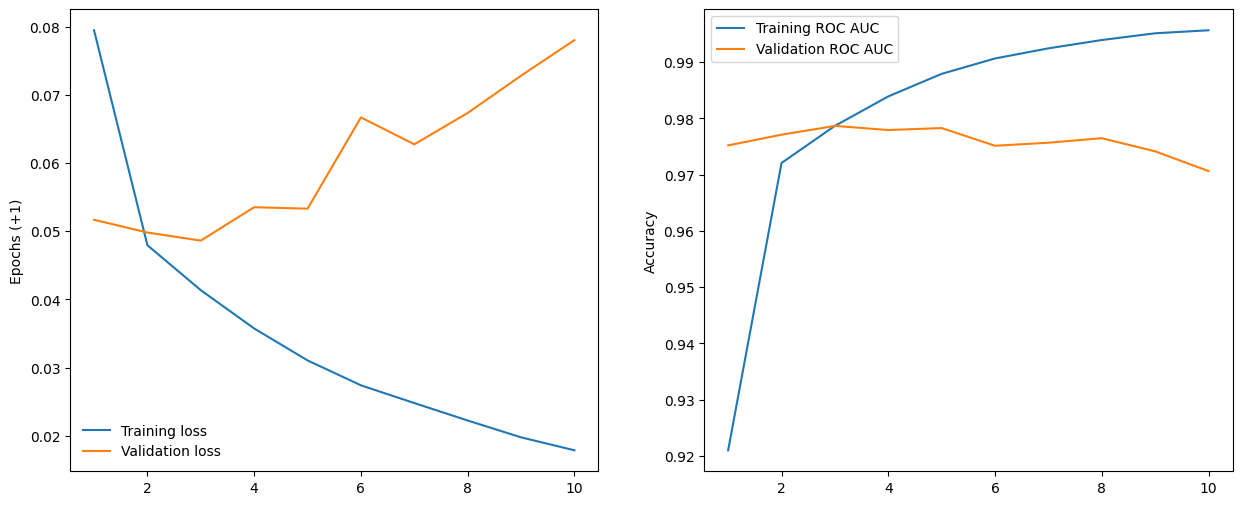

In [96]:
render_history(history)

# Retrain model

In [97]:
SELECTED_N_EPOCHS = 2

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
model = ToxicClassifier(
    EMBEDDING_DIM,
    HIDDEN_DIM,
    NUM_FILTERS,
    KERNEL_SIZE,
    DROPOUT,
    NUM_CLASSES)
model.to(DEVICE)
    
# Loss
criterion = nn.BCEWithLogitsLoss() # Multi-label loss
    
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
history = model_train(model, train_dataloader, val_dataloader, criterion, optimizer, SELECTED_N_EPOCHS, DEVICE)

Epoch 1/2
Train Loss: 0.0789 | AUC_ROC: 0.9237
Val Loss: 0.0516 | AUC_ROC: 0.9747
Epoch 2/2
Train Loss: 0.0483 | AUC_ROC: 0.9721
Val Loss: 0.0492 | AUC_ROC: 0.9767


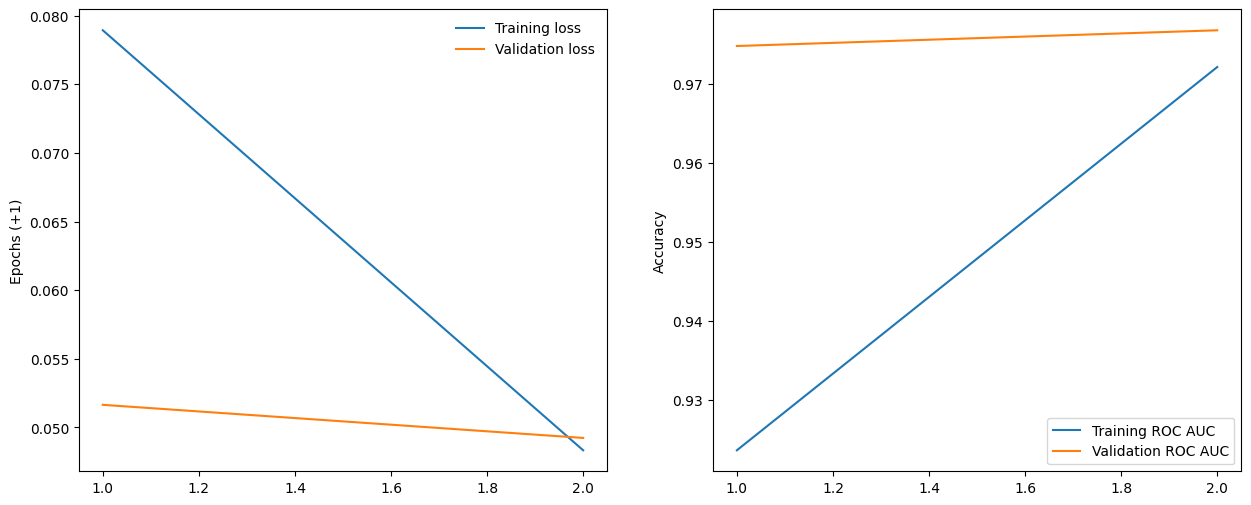

In [98]:
render_history(history)

# Save model and files

In [99]:
# Save Model Weights
torch.save(model.state_dict(), "../model/model.pth")

# Save Vocabulary 
json.dump(vocab, open("../model/vocab.json", "w"))

# Save Tokenizer
# see script in utils

# Save Hyperparameters
# (to recreate the model architecture)
config = {
    "embedding_dim": EMBEDDING_DIM,
    "hidden_dim": HIDDEN_DIM,
    "num_filters": NUM_FILTERS,
    "kernel_size": KERNEL_SIZE,
    "dropout": DROPOUT,
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "max_len": MAX_LEN,
    "num_classes": NUM_CLASSES  # toxic, severe_toxic, obscene, threat, insult, identity_hate
}
json.dump(config, open("../model/config.json", "w"))
